# What makes a Kaggle competition popular?

The code first takes a simple copy-paste of Kaggle's competition page and transform it into a clean, usable dataframe (Part I: Data cleaning and preparation). It then uses gradient boosted decision trees as a machine learning model (Part II: Machine Learning). Finally, using feature importance, characteristics of popular Kaggle competitions are revealed (Part III: Results).

## Part I: Data cleaning and preparation

All data is contained within a text file. It is a copy-paste of Kaggle's competition page (1) that abides by Kaggle restrictions on web scraping (2). The following cells show how the text is cleaned and processed into a dataframe ready to be used for machine learning.

*(1) https://www.kaggle.com/competitions?sortBy=recentlyCreated&group=general&page=1&pageSize=20, accessed 14/08/2019*<br>
*(2) https://www.kaggle.com/terms, accessed 14/08/2019*

First, let's read in the text file and remove any formatting, header and footer.

In [1]:
# READ DATA
with open('kaggle_competitions.txt') as f: # open .txt file
    doc = f.readlines() # read .txt line by line

# CLEAN DATA
doc = [line.rstrip('\n') for line in doc] # remove trailing \n for each string
doc = [i for i in doc if i] # remove empty strings

# REMOVE HEADER AND FOOTER
start_index = [index for index, string in enumerate(doc) if 'Ciphertext Challenge III' in string][0] # identify start index
end_index = [index for index, string in enumerate(doc) if 'No more competitions to show' in string][0] # identify end index
doc = doc[start_index:end_index] # remove header and footer

print('\nSample:') # print 'Sample:'
doc[:17] # show sample


Sample:


['Ciphertext Challenge III',
 'Ciphertext Challenge III',
 'BRBTvl0LNstxQLyxulCEEq1czSFje0Z6iajczo6ktGmitTE=',
 'Playground',
 '22 days to go',
 ' poetry, text data',
 'Swag',
 '49 teams',
 'Severstal: Steel Defect Detection',
 'Severstal: Steel Defect Detection',
 'Can you detect and classify defects in steel?',
 'Featured',
 'Kernels CompetitionSubmission is through Kaggle Kernels.Learn more.',
 '2 months to go',
 ' image data, manufacturing',
 '$120,000',
 '540 teams']

Next, the dataset is split by competition and saved in a dictionary.

In [2]:
# IDENTIFY COMPETITION SUBSET BOUNDARIES
i = 0 # create variable to iterate over using 'while'
boundary_indices = [] # create empty list 

while i < len(doc): # while the end of document is not reached, proceed
    if doc[i].find('teams') > 0: # if keyword 'teams' is found
        temp_index = i+1 # store index of string within list +1
        boundary_indices.append(temp_index) # apprend it to boundary_indices list
    if i>10 and i-temp_index > 10: # if there are more than 10 strings between the last 'teams' found and the current string
        for j in range(i-6, i): # going back 6 strings
            prize_keywords = ['€', '$', 'Jobs', 'Knowledge', 'Kudos', 'Swag', 'USD'] # using a list of prize-related keywords
            if any(keyword in doc[j] for keyword in prize_keywords): # where found
                temp_index = j+1 # store index of string containing prize information +1
                boundary_indices.append(temp_index) # append it to boundary_indices list
    i +=1 # proceed to next iteration

# EXTRACT COMPETITION FEATURES FROM EACH SUBSET
competitions = {} # create empty dictionary

for i in range(len(boundary_indices)): # for boundary indices identified
    if i == 0: # at first iteration
        subset = doc[:boundary_indices[i]] # start from 0 to the first boundary index
    else: # then
        subset = doc[boundary_indices[i-1]:boundary_indices[i]] # from boundary index to the next
        
    temp_competition = subset[0] # competition name is the first element
    temp_summary = subset[2] # summary is the third element
    temp_category = subset[3] # category is the fourth element
    
    temp_kernel = 0 # kernel is by default 0 (i.e. is the competition a kernel competition)
    temp_timeline = '' # create empty string
    temp_tags = '' # create empty string
    temp_prize = '' # create empty string
    temp_teams = '' # create empty string
    
    for j in range(len(subset)): # for length of subset
        if 'Kernels Competition' in subset[j]: # if competition is a Kernels Competition
            temp_kernel = 1 # kernel equals 1
        if any(keyword in subset[j] for keyword in ['ago', 'Ongoing', 'to go']): # if timeline keyword found in subset
            temp_timeline = subset[j] # update timeline value 
            index_timeline = j # take note of timeline index
        if j==len(subset)-1 and any(keyword in subset[int(index_timeline)+1] for keyword in ['€', '$', 'Jobs', 'Knowledge', 'Kudos', 'Swag', 'USD']) == False:
            # if penultimate string does not contain prize information
            temp_tags = subset[int(index_timeline)+1] # store as tags
        if any(keyword in subset[j] for keyword in ['€', '$', 'Jobs', 'Knowledge', 'Kudos', 'Swag', 'USD']): # if prize keyword found
            temp_prize = subset[j] # update prize value
        if any(keyword in subset[j] for keyword in ['teams']): # if teams appear
            temp_teams = subset[j] # update teams value
    
    competitions[temp_competition.strip()] = [temp_summary.strip(),
                                              temp_category.strip(),
                                              temp_kernel,
                                              temp_timeline.strip(),
                                              temp_tags.strip(),
                                              temp_prize.strip(),
                                              temp_teams.strip()
                                             ] # store values within a dictionary entry

print('\nSample:') # print 'Sample:'
competitions['Instant Gratification'] # show sample


Sample:


['A synchronous Kernels-only competition',
 'Featured',
 1,
 '2 months ago',
 'tabular data, binary classification',
 '$5,000',
 '1,832 teams']

In turn, the dictionary is transformed into a dataframe.

In [3]:
# CREATE DATAFRAME
import pandas as pd # import data manipulation and analysis library
df = pd.DataFrame(competitions).transpose() # create dataframe from dictionary
df = df.reset_index() # reset index
df.columns = ['competition', 'summary', 'category', 'is_kernel', 'timeline', 'tags', 'prize', 'teams'] # name columns
df = df[df.teams!=''] # remove competitions with no information on number of teams participating
df = df[df['timeline'].str.contains('ago')] # remove active competitions
df.reset_index(inplace=True, drop=True) # reset index

print('\nSample:') # print 'Sample:'
df.head(1) # show sample


Sample:


,competition,summary,category,is_kernel,timeline,tags,prize,teams
0,Instant Gratification,A synchronous Kernels-only competition,Featured,1,2 months ago,"tabular data, binary classification","$5,000","1,832 teams"


To be able to use text-based features in the model, the text first needs to be simplified. The goal is to avoid slightly different words referring to the same concept. For instance, 'Predict' and 'predict' can be lowercased to avoid this situation.

In [4]:
# PREPROCESS STRINGS
import re # import regular expression library
import spacy # import natural language processing library

nlp = spacy.load('en_core_web_sm') # load spacy vocabulary

columns = ['competition', 'summary'] # store names of columns to be processed

for column in columns: # for each column to be processed
    
    temp_vals = [] # create empty list

    for element in df[column]: # for each row of each column to be processed

        temp = element # create temp object containing string value
        temp = temp.lower() # lowercase string
        temp = re.sub(r'[^a-zA-Z\s]', ' ', temp) # remove numbers and punctuation
        
        temp = nlp(temp) # process string through spacy
        temp_lemmas = [] # create empty list

        for i in range(len(temp)): # for each token
            if nlp.vocab[str(temp[i])].is_stop or nlp.vocab[temp[i].lemma_].is_stop: # if token or its lemma is a stop word
                temp_lemmas.append('') # append empty string
            else: # otherwise, if token or its lemma is not a stop word
                temp_lemmas.append(temp[i].lemma_) # add lemma to temporary object

        temp = ' '.join(temp_lemmas) # reform string from lemmas
        temp_vals.append(temp) # append string to temp_vals list
    
    temp_column_name = column+'_clean' # create new column name 
    df[temp_column_name] = temp_vals # create new columns and fill it with clean strings

print('\nSample:') # print 'Sample:'
df.head(1) # show sample


Sample:


,competition,summary,category,is_kernel,timeline,tags,prize,teams,competition_clean,summary_clean
0,Instant Gratification,A synchronous Kernels-only competition,Featured,1,2 months ago,"tabular data, binary classification","$5,000","1,832 teams",instant gratification,synchronous kernel competition


Moreover, the prize column consists of both pure text (e.g. 'Knowledge') and text and figures (e.g. '$5,000') and needs to be reformatted.

In [5]:
# CREATE A DOLLAR_PRIZE AND OTHER_PRIZE COLUMNS
dollar_prize = [] # create empty list
other_prize = [] # create empty list

for item in df.prize: # for row in prize column
    
    temp = item.replace(',', '') # remove commas
    
    if temp[0] == '$': # if prize is in $
        dollar_prize_temp = int(temp.replace('$', '')) # dollar figure
        other_prize_temp = '' # empty string
        
    if temp[0] == '€': # if prize is in € 
        dollar_prize_temp = int(int(temp.replace('€', ''))*1.11)  # convert to $ using 16/08/2019, 15:45 UTC rate of exchange
        other_prize_temp = '' # empty string
        
    if temp[0] != '$' and temp[0] != '€': # if prize is not in $ or €
        dollar_prize_temp = 0 # 0 as dollar figure
        other_prize_temp = temp # string
        
    dollar_prize.append(dollar_prize_temp) # append dollar figure
    other_prize.append(other_prize_temp) # append string

df['dollar_prize'] = dollar_prize # create column
df['other_prize'] = other_prize # create column

print('\nSample:') # print 'Sample:'
df.head(1) # show sample


Sample:


,competition,summary,category,is_kernel,timeline,tags,prize,teams,competition_clean,summary_clean,dollar_prize,other_prize
0,Instant Gratification,A synchronous Kernels-only competition,Featured,1,2 months ago,"tabular data, binary classification","$5,000","1,832 teams",instant gratification,synchronous kernel competition,5000,


To be used by machine learning, all text needs to be encoded as numbers. Here, each unique word within each column is identified. Then, a separate column is created for each word. At each row, a value indicates the absence (0) or presence (1) of the token in the original column.

In [6]:
string_columns = ['competition_clean', 'summary_clean', 'category', 'tags', 'other_prize'] # list of relevant columns

for column in string_columns: # for each relevant column
    
    if column == 'tags': # if column name is tags
        separator = ',' # then values are separated by commas
    
    else: # otherwise
        separator = ' ' # values are separated by blank spaces
        
    # CREATE VOCABULARY OF UNIQUE TOKENS
    temp = df[column].str.split(separator, expand=True) # create a temporary object holding tokens in separate columns
    temp_vocab = [] # create a temporary vocabulary holder

    for i in temp.columns: # loop over columns
        temp_vocab.append([item for item in temp[i].unique()]) # append unique column vocabulary to temporary vocabulary holder

    temp_vocab = [item for sublist in temp_vocab for item in sublist] # flatten list of lists
    temp_vocab = list(set(temp_vocab)) # deduplicate tokens present in multiple columns
    temp_vocab = [item for item in temp_vocab if item] # remove None values and empty strings
    temp_vocab = [item.strip() for item in temp_vocab] # remove whitespaces
    
    # CREATE BINARY COLUMNS
    for token in temp_vocab: # for unique token found in original column
        
        temp_binary = [] # create empty list

        for value in df[column]: # for each row
            if token in [i.strip() for i in value.split(separator)]: # if token is found
                temp_binary.append(1) # append 1
            else: # otherwise
                temp_binary.append(0) # append 0
        
        if len(token) > 1: # if token is more than 1 character long
            binary_column_name = column.replace('_clean', '')+'_'+token # create column name
            df[binary_column_name] = temp_binary # create column and fill it with 0 (absence) or 1 (presence) at each row

print('\nSample:') # print 'Sample:'
df.head(1) # show sample


Sample:


,competition,summary,category,is_kernel,timeline,tags,prize,teams,competition_clean,summary_clean,...,tags_medicine,tags_ecology,tags_crowdfunding,tags_automobiles,tags_painting,other_prize_USD,other_prize_Jobs,other_prize_Knowledge,other_prize_Kudos,other_prize_Swag
0,Instant Gratification,A synchronous Kernels-only competition,Featured,1,2 months ago,"tabular data, binary classification","$5,000","1,832 teams",instant gratification,synchronous kernel competition,...,0,0,0,0,0,0,0,0,0,0


Finally, remaining string features – e.g. '1,832 teams' – are transformed into integers – e.g. 1832.

In [7]:
# CONVERT TIMELINE FEATURE TO INTEGER
temp = [] # create temporary list

for i in range(len(df.timeline)): # for each row in timeline column
    if 'a month' in df.timeline[i] or 'months' in df.timeline[i] or 'days' in df.timeline[i]: # if timeline within a year
        temp.append(0) # append 0
    else: # otherwise
        if df.timeline[i][0] == 'a': # if timeline starts with 'a'
            temp.append(1) # append 1
        else: # if it does not
            temp.append(int(df.timeline[i][0])) # append n years ago as integer

df['years_ago'] = temp # create column

# CONVERT TEAMS FEATURE TO INTEGER
df.teams = [i.rstrip(' teams') for i in df.teams] # remove trailing ' teams'
df.teams = [i.replace(',', '') for i in df.teams] # remove any ',' character representing thousands
df.teams = [int(i) for i in df.teams] # convert to int

print('\nSample:') # print 'Sample:'
df.head(1) # show sample


Sample:


,competition,summary,category,is_kernel,timeline,tags,prize,teams,competition_clean,summary_clean,...,tags_ecology,tags_crowdfunding,tags_automobiles,tags_painting,other_prize_USD,other_prize_Jobs,other_prize_Knowledge,other_prize_Kudos,other_prize_Swag,years_ago
0,Instant Gratification,A synchronous Kernels-only competition,Featured,1,2 months ago,"tabular data, binary classification","$5,000",1832,instant gratification,synchronous kernel competition,...,0,0,0,0,0,0,0,0,0,0


The dataframe is now ready to be used by a machine learning model.

## Part II: Machine Learning

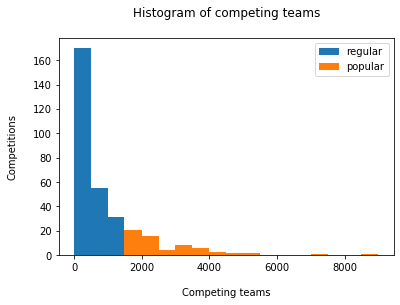

In [8]:
# CREATE A LABEL COLUMN
df['label'] = df['teams'] # create label column from teams column
df.loc[df['label']<df.teams.quantile(0.8), 'label'] = 0 # if participation is regular (bottom 80% competitions), label as 0
df.loc[df['label']>df.teams.quantile(0.8), 'label'] = 1 # if participation is high (top 20% competitions), label as 1

# VISUALISE 
%matplotlib inline
# use matplotlib inline
import matplotlib.pyplot as plt # import plotting library

regular = df.teams[df.teams<1489] # create dataset of bottom 80% competitions
popular = df.teams[df.teams>1489] # create dataset of top 20% competitions
bins = [i for i in range(0, 9001, 500)] # create bins
bins[3] = 1489 # update 1500 as 1489, which in turn will sightly change the width and height of bars between 1000 and 2000 below 

plt.hist(regular, bins, label='regular') # plot histogram
plt.hist(popular, bins, label='popular') # plot histogram

plt.legend(loc='upper right') # set legend
plt.title('Histogram of competing teams\n') # set title
plt.xlabel('\nCompeting teams') # set x label
plt.ylabel('Competitions\n') # set y label
plt.show() # show histogram

Using the dataframe, a machine learning model will attempt to predict one of two possible classes:
<br>-> 0 (bottom 80% competitions, with less than 1489 competing teams, referred to as 'regular')
<br>-> 1 (top 20% competitions, with more than 1489 competing teams, referred to as 'popular')

In [9]:
from sklearn import metrics # import machine learning metrics from sklearn library
from sklearn.model_selection import train_test_split # import cross validation method from sklearn library
import xgboost as xgb # import gradient boosted decision trees library

X = df.loc[:, df.columns!='teams'].select_dtypes(exclude=['object']) # select dataframe except string columns and teams
X = X.loc[:, X.columns!='label'] # exclude label column
y = df['label'] # retain label column as y

X_train, X_test, y_train, y_test = train_test_split(X, # split X
                                                    y, # and y
                                                    test_size=.1, # with 90% training, 10% testing
                                                    random_state=0) # and a random state to be able reproduce results

clf = xgb.XGBClassifier(n_estimators=500, # 500 trees
                        n_jobs=4, # allow for parallel threading
                        max_depth=9, # control size of trees
                        learning_rate=0.05) # set learning rate
clf.fit(X_train, y_train) # fit classifier

# PREDICT
predictions = clf.predict(X_test) # predict

# PRINT METRICS
print('\nAccuracy:', metrics.accuracy_score(y_test, predictions)) # print accuracy
print('Shape of dataframe:', df.shape) # print (number of rows, number of columns)
cm = pd.DataFrame(metrics.confusion_matrix(y_test, predictions), # prepare confusion matrix as dataframe
                  index=['actual regular','actual popular'], # with relevant row names
                  columns=['predicted regular','predicted popular']) # and column names
print('\nConfusion matrix:\n', cm) # print confusion matrix


Accuracy: 0.90625
Shape of dataframe: (320, 1793)

Confusion matrix:
                 predicted regular  predicted popular
actual regular                 22                  2
actual popular                  1                  7


The machine learning model used here is an XGBoost classifier. It implements gradient boosted decision trees and among other things, returns feature importance.

Despite the low number of records (320 rows) and high-dimensionality (1793 columns) of the dataset, it achieves about 90% accuracy on test data.

In the next part of the notebook, I will use what the model has learned – what features it found informative – as a way to explore Kagglers' motivations and determine what makes a Kaggle competition popular.

## Part III: Results

## (a) Feature importance

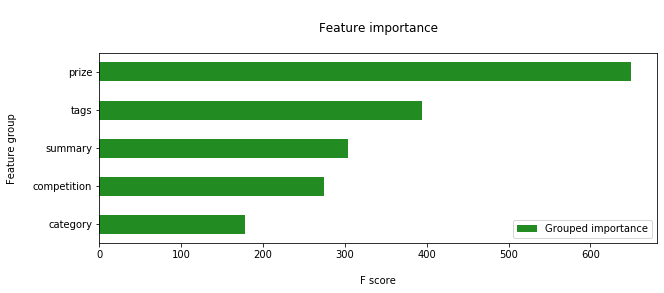

In [10]:
# SAVE FEATURE IMPORTANCE (TOTAL GAIN) AS DATAFRAME
results = clf.get_booster().get_score(importance_type='total_gain') # store feature importance key-values
results = pd.DataFrame(results.items()) # convert to dataframe
results.columns = ['feature', 'importance'] # rename columns
results.sort_values(['importance'], ascending=False, inplace=True) # sort values
results.reset_index(inplace=True, drop=True) # reset index

grouped_results = {} # create empty dictionary

grouped_results['competition'] = results[results.feature.str.contains('competition_')]['importance'].sum() # group importance
grouped_results['summary'] = results[results.feature.str.contains('summary_')]['importance'].sum() # group importance
grouped_results['category'] = results[results.feature.str.contains('category_')]['importance'].sum() # group importance
grouped_results['tags'] = results[results.feature.str.contains('tags_')]['importance'].sum() # group importance
grouped_results['prize'] = results[results.feature.str.contains('prize')]['importance'].sum() # group importance

grouped_results = pd.DataFrame(list(grouped_results.items())) # convert dictionary to dataframe
grouped_results.columns = ['Grouped features', 'Grouped importance'] # rename columns
grouped_results.sort_values('Grouped importance', inplace=True) # sort values
grouped_results.set_index('Grouped features', inplace=True) # set feature group as index

ax = grouped_results.plot(kind='barh', stacked=False, figsize=(10, 3.5), color='forestgreen') # plot grouped results
ax.set_ylabel('Feature group\n') # set y label
plt.xlabel('\nF score') # set x label
plt.title('\nFeature importance\n') # set title
plt.show() # show horizontal bar chart

Here, feature importance represents how frequent and informative features are across all decision trees.

Overall, the popularity of competitions is most associated with the prize to be won. Then come keywords within tags, summary, competition name and the category of the competition.

Let's explore each one by one.

## (b) Prizes

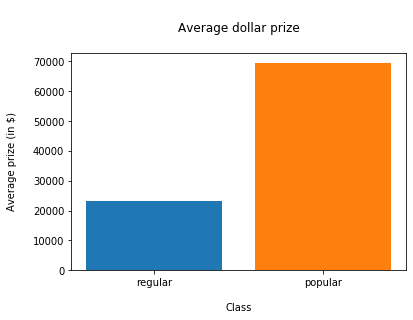

In [11]:
# VISUALISE AVERAGE DOLLAR PRIZE ACROSS CLASSES
sub_results = df[['label', 'dollar_prize']].groupby('label').mean() # group dollar prize information by label
plt.bar([0,1], sub_results['dollar_prize'], color=['#1f77b4', '#ff7f0e']) # create bar chart
plt.xticks([0,1], ['regular', 'popular']) # set x ticks
plt.title('\nAverage dollar prize\n') # set title
plt.xlabel('\nClass') # set x label
plt.ylabel('Average prize (in $)\n') # set y label
plt.show() # show bar chart

The first motivational factor seems to be the dollar prize.

On average, competitions offer a cash prize of \$32,357.

Bottom 80% competitions offer a \$23,083 prize on average, versus $69,453 for top 20% competitions.

However, money itself might not be the motivation of many Kagglers. A high-value cash prize can also indicate how challenging a problem is – i.e. how much can be learned – or how much an organisation values its resolution – i.e. how valuable a Kaggler's new skills may be.

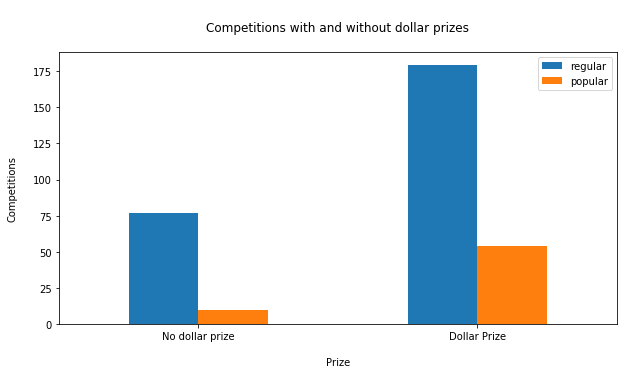

In [12]:
# VISUALISE COMPETITIONS WITH AND WITHOUT DOLLAR PRIZES ACROSS CLASSES
z_r = len(df[(df['dollar_prize']==0) & (df.label==0)]) # count of $0 prize regular competitions
z_p = len(df[(df['dollar_prize']==0) & (df.label==1)]) # count of $0 prize popular competitions
d_r = len(df[(df['dollar_prize']>0) & (df.label==0)]) # count of $n prize regular competitions
d_p = len(df[(df['dollar_prize']>0) & (df.label==1)]) # count of $n prize popular competitions

data = {'regular': [z_r, d_r], 'popular': [z_p, d_p]} # create dictionary
viz_df = pd.DataFrame(data, index=pd.Index(['No dollar prize','Dollar Prize'], name='\nPrize')) # create dataframe

ax = viz_df.plot(kind='bar', stacked=False, figsize=(10, 5)) # plot bar chart
ax.set_ylabel('Competitions\n') # set y label
plt.xticks(rotation=0) # set x tick rotation
plt.title('\nCompetitions with and without dollar prizes\n') # set title
plt.show() # show bar chart

Competitions with dollar prizes are more likely to be popular than those offering other prizes.

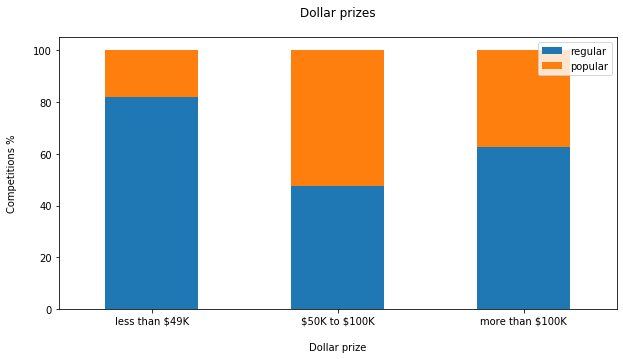

In [13]:
# VISUALISE BINNED DOLLAR PRIZES ACROSS CLASSES
viz_df = df[['dollar_prize','label']] # create subset

regular = [] # create empty list
popular = [] # create empty list

for i, j in [(1,49999), (50000,99999), (100000, 1500000)]: # for each bin between amount and amount
    subset_viz_df = viz_df[(viz_df['dollar_prize']>=i) & (viz_df['dollar_prize']<=j)] # subset data
    count_regular = len(subset_viz_df[subset_viz_df['label']==0]) # count of regular competitions
    count_popular = len(subset_viz_df[subset_viz_df['label']==1]) # count of popular competitions
    
    regular.append(count_regular/(count_regular+count_popular)*100.0) # append % of regular competitions
    popular.append(count_popular/(count_regular+count_popular)*100.0) # append % of popular competitions
    
data = {'regular': regular, 'popular': popular} # create dictionary
viz_df = pd.DataFrame(data, index=pd.Index(['less than $49K', '\$50K to $100K', 'more than $100K'], name='\nDollar prize'))
# create dataframe

ax = viz_df.plot(kind='bar', stacked=True, figsize=(10, 5)) # create stacked bar chart
ax.set_ylabel('Competitions %\n') # set y label
plt.xticks(rotation=0) # set x tick rotation
plt.title('Dollar prizes\n') # set title
plt.show() # show stacked bar chart

In addition, the dollar amount matters, with competitions offering higher amounts typically attracting more teams.

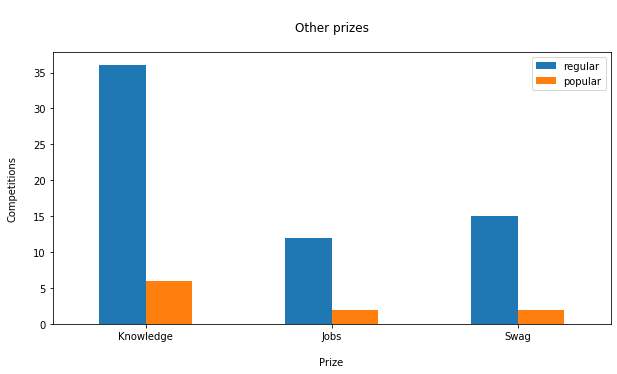

In [14]:
# DEFINE VISUALISATION FUNCTION
def visualise(keyword, title, x_label, x_ticks_rotation): # define function names and parameters

    features = [i for i in results[results.feature.str.contains(keyword)]['feature']] # subset based on keyword
    feature_index, feature_regular, feature_popular = [], [], [] # create empty lists

    for i in features: # for each feature
        feature_index.append(i[len(keyword):]) # store name
        feature_regular.append(len(df[(df[i]==1) & (df.label==0)])) # store count of regular competitions
        feature_popular.append(len(df[(df[i]==1) & (df.label==1)])) # store count of popular competitions

    data = {'regular': feature_regular, 'popular': feature_popular} # create dictionary
    viz_df = pd.DataFrame(data, index=pd.Index(feature_index, name=x_label)) # create dataframe

    ax = viz_df.plot(kind='bar', stacked=False, figsize=(10, 5)) # create stacked bar chart
    ax.set_ylabel('Competitions\n') # set y label
    plt.xticks(rotation=x_ticks_rotation) # set x tick rotation
    plt.title(title) # set title
    plt.show() # show stacked bar chart

visualise(keyword='other_prize_', title='\nOther prizes\n', x_label='\nPrize', x_ticks_rotation=0) # call function

Finally, competitions with non-cash prizes prove less popular.

## (c) Tags

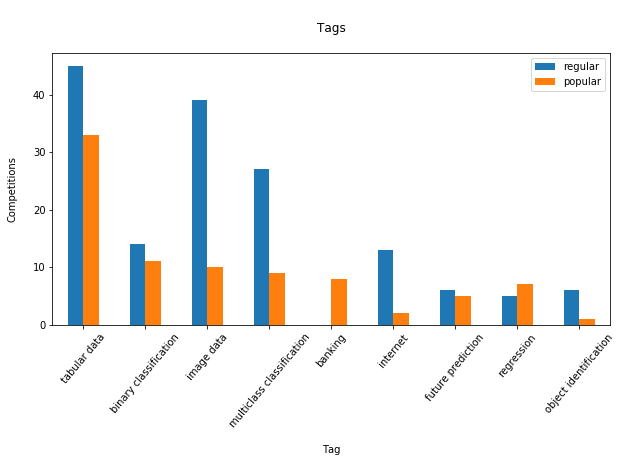

In [15]:
visualise(keyword='tags_', title='\nTags\n', x_label='\nTag', x_ticks_rotation=50) # call function

Here, we see competitions related to banking and regression prove particularly popular. Tabular data, binary classification and future prediction tags also do well.

## (d) Summary

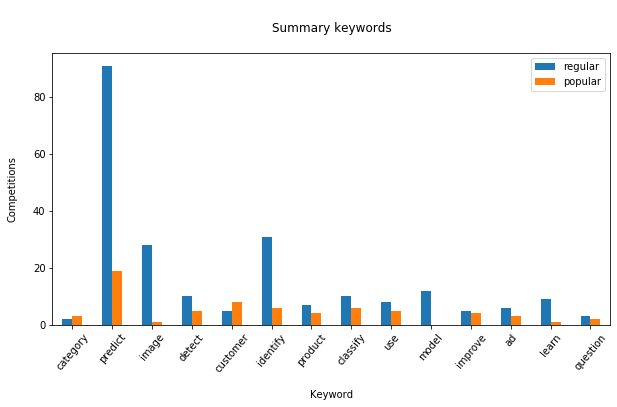

In [16]:
visualise(keyword='summary_', title='\nSummary keywords\n', x_label='\nKeyword', x_ticks_rotation=50) # call function

Summaries with keywords 'category', 'detect', 'customer', 'product', 'classify', 'use', 'improve', 'ad' and 'question' within the summary tend to be more popular.

## (e) Competition names

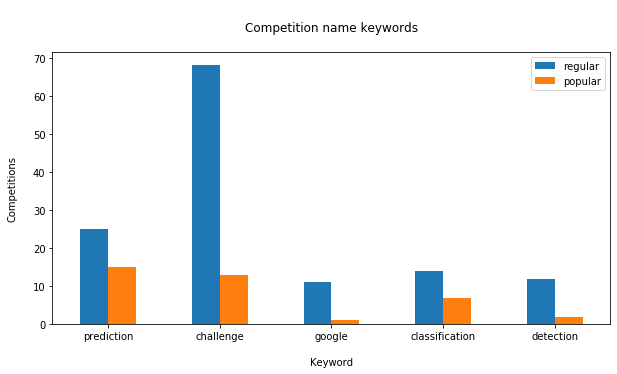

In [17]:
visualise(keyword='competition_', title='\nCompetition name keywords\n', x_label='\nKeyword', x_ticks_rotation=0) # call function

Within competition names, the keywords 'prediction' and 'classification' are associated with a higher proportion of popular competitions.

## (f) Category

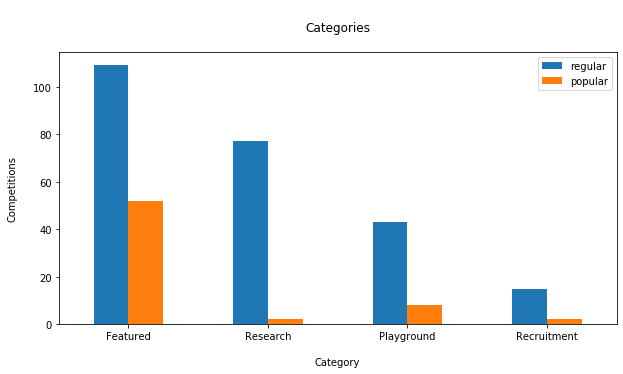

In [18]:
visualise(keyword='category_', title='\nCategories\n', x_label='\nCategory', x_ticks_rotation=0) # call function

Finally, competitions categorised as 'Featured' are most popular.

## (g) Conclusion

To sum up, a popular Kaggle competition, among the top 20% most attended, is likely to:
<br>-> offer an above-average dollar prize
<br>-> feature tags such as 'banking', 'regression', 'tabular data', 'binary classification' or 'future prediction'
<br>-> have the keywords 'category', 'detect', 'customer', 'product', 'classify', 'use', 'improve', 'ad' or 'question' in the competition summary
<br>-> have the keywords 'prediction' or 'classification' in the competition name
<br>-> be categorised by Kaggle as 'Featured'